# Optimized Cat-Dog Image Classification Using Transfer Learning and Hyperparameter Tuning with Keras-Tuner
Authors: Joel Enrique Díaz Villanueva   
Organisation: Universidad de Monterrey   
Created: Sunday 29 June 2025   

---
    

<a name='required-standard-libraries'></a>
### Required standard libraries

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.7 MB/s eta 0:00:00


In [52]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import cv2
from datetime import datetime

<a name='preprocessing-the-dataset'></a>
#### Preprocessing the dataset

In [3]:
!unzip '/content/test_set.zip'
!unzip '/content/training_set.zip'

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: training_set/cats/cat.3705.jpg  
  inflating: training_set/cats/cat.3706.jpg  
  inflating: training_set/cats/cat.3707.jpg  
  inflating: training_set/cats/cat.3708.jpg  
  inflating: training_set/cats/cat.3709.jpg  
  inflating: training_set/cats/cat.371.jpg  
  inflating: training_set/cats/cat.3710.jpg  
  inflating: training_set/cats/cat.3711.jpg  
  inflating: training_set/cats/cat.3712.jpg  
  inflating: training_set/cats/cat.3713.jpg  
  inflating: training_set/cats/cat.3714.jpg  
  inflating: training_set/cats/cat.3715.jpg  
  inflating: training_set/cats/cat.3716.jpg  
  inflating: training_set/cats/cat.3717.jpg  
  inflating: training_set/cats/cat.3718.jpg  
  inflating: training_set/cats/cat.3719.jpg  
  inflating: training_set/cats/cat.372.jpg  
  inflating: training_set/cats/cat.3720.jpg  
  inflating: training_set/cats/cat.3721.jpg  
  inflating: training_set/cats/cat.3722.jpg  
  inflating: training

In [4]:
train_dir = '/content/training_set'
validation_dir = '/content/test_set'

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            )

Found 8005 files belonging to 2 classes.


In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 )

Found 2023 files belonging to 2 classes.


In [7]:
class_names = train_dataset.class_names
print(class_names)

['cats', 'dogs']


Autotune implemtation for faster training

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.shuffle(1000).prefetch(AUTOTUNE)
val_dataset = validation_dataset.prefetch(AUTOTUNE)

<a name='preprocessing-the-dataset'></a>
#### Data Augmentation

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

<a name='preprocessing-the-dataset'></a>
#### MobileNetV2 Download

In [10]:
base_model = MobileNetV2(input_shape = (224,224,3), include_top=False, weights='imagenet')

base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of layers in the base model:  154


Fine Tuning from layers 75 to 154

In [11]:
fine_tune_at = 75

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

<a name='preprocessing-the-dataset'></a>
#### Keras-Tuner Implementation

In [12]:
def model_builder(hp):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.mobilenet.preprocess_input(x)  # Scales data
    x = base_model(x)
    x = tf.keras.layers.Flatten()(x)

    # Tune weight decay
    weight_decay = hp.Float("weight_decay", min_value=1e-10, max_value=1e-3, sampling="log")

    # Tune the number of dense layers
    for i in range(hp.Int("num_layers", 1, 2)):
        x = tf.keras.layers.Dense(
            units=hp.Int(f"units_{i}", min_value=256, max_value=512, step=32),
            activation=hp.Choice("activation", ["relu", "swish"]),
            kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)

    # Tune dropout
    if hp.Boolean("dropout"):
        x = tf.keras.layers.Dropout(rate=0.25)(x)

    # Output layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Tune learning rate
    learning_rate = hp.Float("lr", min_value=1e-8, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy", tf.keras.metrics.AUC(name='auc')],
    )
    return model

In [13]:
'''
tuner = kt.Hyperband(model_builder,
                     objective='val_auc',
                     max_epochs=5,
                     factor=3,
                     overwrite=True
                     )
'''
tuner = kt.BayesianOptimization(
    model_builder,
    objective='val_auc',
    max_trials=3,
    alpha=0.0001,
    beta=2.6,
    overwrite=True
)

In [14]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
weight_decay (Float)
{'default': 1e-10, 'conditions': [], 'min_value': 1e-10, 'max_value': 0.001, 'step': None, 'sampling': 'log'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'swish'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-08, 'conditions': [], 'min_value': 1e-08, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [15]:
early_stopping = EarlyStopping(
    patience=3,
    monitor='val_auc',
    restore_best_weights=True,
    mode='max',
    verbose=1
)

In [16]:
tuner.search(train_dataset, epochs=4, validation_data = validation_dataset, callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 3 Complete [00h 05m 22s]
val_auc: 0.998275876045227

Best val_auc So Far: 0.998275876045227
Total elapsed time: 00h 14m 08s


In [17]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_auc", direction="max")

Trial 2 summary
Hyperparameters:
weight_decay: 1.4818965647918362e-10
num_layers: 1
units_0: 288
activation: relu
dropout: False
lr: 1.0379217790066225e-06
Score: 0.998275876045227

Trial 1 summary
Hyperparameters:
weight_decay: 2.249021736277727e-06
num_layers: 1
units_0: 320
activation: swish
dropout: False
lr: 0.00012205160833086806
Score: 0.9967682361602783

Trial 0 summary
Hyperparameters:
weight_decay: 8.910421239836259e-10
num_layers: 1
units_0: 384
activation: relu
dropout: True
lr: 1.1680623469968179e-06
Score: 0.99607914686203


<a name='preprocessing-the-dataset'></a>
#### Training the model with the best hyperparameters using the full data

In [18]:
early_stopping = EarlyStopping(patience=3, monitor='auc', restore_best_weights=True, mode='max', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.333,
                              patience=3, min_lr=0.00000000000001)

In [19]:
full_train_dataset = train_dataset.concatenate(validation_dataset)

<a name='training-the-neural-network-model'></a>
#### Training the neural network model

In [20]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(full_train_dataset, epochs=20, callbacks = [early_stopping, reduce_lr])

Epoch 1/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 66s 127ms/step - accuracy: 0.8271 - auc: 0.8915 - loss: 0.3687 - learning_rate: 1.0379e-06
Epoch 2/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9661 - auc: 0.9952 - loss: 0.0903 - learning_rate: 1.0379e-06
Epoch 3/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.9666 - auc: 0.9954 - loss: 0.0839 - learning_rate: 1.0379e-06
Epoch 4/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.9701 - auc: 0.9956 - loss: 0.0827 - learning_rate: 1.0379e-06
Epoch 5/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.9727 - auc: 0.9967 - loss: 0.0691 - learning_rate: 1.0379e-06
Epoch 6/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9766 - auc: 0.9972 - loss: 0.0641 - learning_rate: 1.0379e-06
Epoch 7/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 46s 124ms/step - accuracy: 0.9791 - auc: 0.9977 - loss: 0.0577 - learning_rate: 1.0379e-06
Epoch 8/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 82s 125ms/step - accuracy: 0.9771 - auc: 0.

In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 288)            │    18,063,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 288)            │         1,152 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,587,525 (231.12 MB)

 Trainable params: 20,132,225 (76.80 MB)

 Non-trainable params: 190,848 (745.50 KB)

 Optimizer params: 40,264,452 (153.60 MB)

<a name='evaluating-the-neural-network-model'></a>
#### Evaluating the neural network model

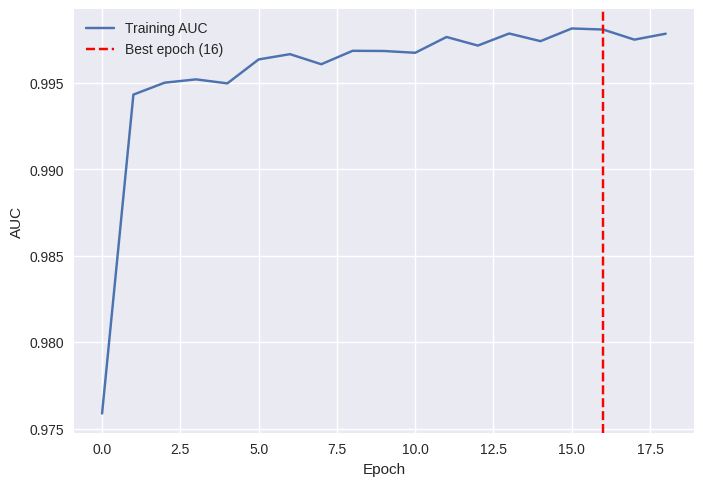

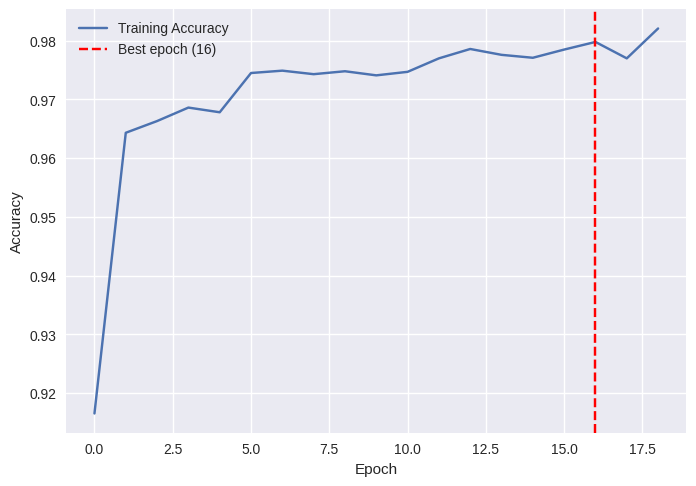

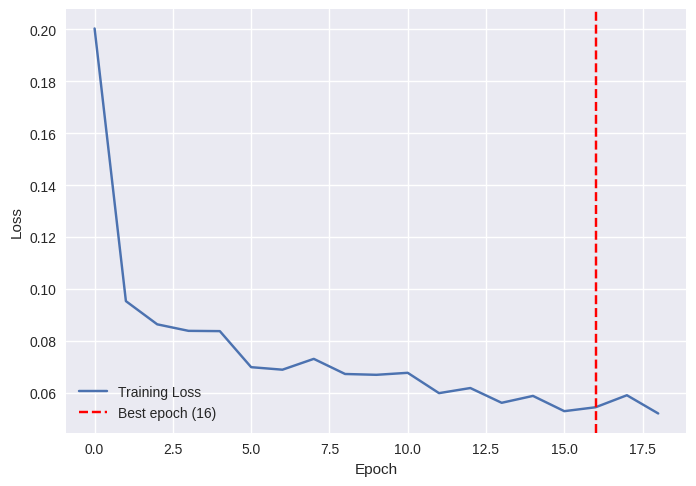

In [58]:
plt.style.use('seaborn-v0_8')

best_epoch = 16  # Best epoch

# AUC
plt.plot(history.history['auc'], label='Training AUC')
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best epoch ({best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best epoch ({best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best epoch ({best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<a name='evaluating-the-neural-network-model-with-training-data'></a>
#### Evaluating the neural network model with the training data

In [24]:
y_true = []
y_pred = []

for images, labels in full_train_dataset:
    y_true.extend(labels.numpy())  # Verdaderas etiquetas
    predictions = model.predict(images);  # Predicciones
    y_pred.extend(predictions.flatten());

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━

<a name='threshold'></a>
#### Obtaining the optimal threshold

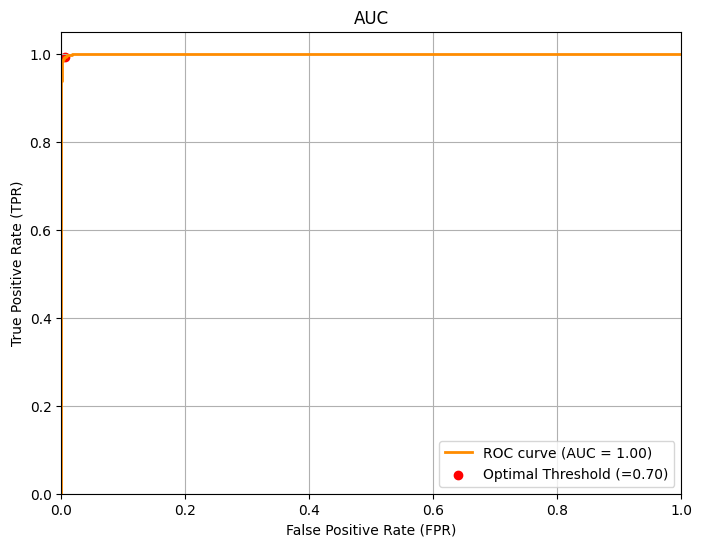

Best Threshold: 0.6972
TPR (Sensitivity): 0.9932
FPR (1-Specificity): 0.0062
AUC: 0.9998


In [53]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred) # Calculate ROC curve

youden_index = tpr - fpr # Calculate Youden's Index to find optimal threshold
best_idx = np.argmax(youden_index)
best_threshold = thresholds[best_idx]

roc_auc = auc(fpr, tpr) # Calculate AUC

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[best_idx], tpr[best_idx], color='red',
            label=f'Optimal Threshold (={best_threshold:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('AUC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print metrics
print(f"Best Threshold: {best_threshold:.4f}")
print(f"TPR (Sensitivity): {tpr[best_idx]:.4f}")
print(f"FPR (1-Specificity): {fpr[best_idx]:.4f}")
print(f"AUC: {roc_auc:.4f}")

<a name='confusion-matrix[texto del enlace](https://)'></a>
#### Confusion Matrix of the training data


Confusion Matrix:


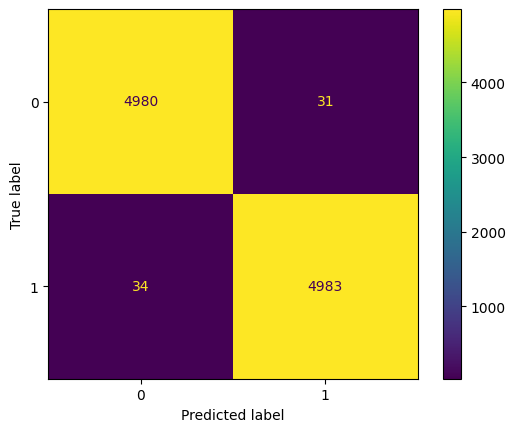

In [54]:
print("\nConfusion Matrix:")
y_predictions = (y_pred >= best_threshold).astype(int)

c_matrix = confusion_matrix(y_true=y_true, y_pred=y_predictions)

display_matrix = ConfusionMatrixDisplay(confusion_matrix=c_matrix)
display_matrix.plot();

<a name='saving-the-neural-network-model'></a>
#### Saving the neural network model

In [29]:
def check_and_create_directory(directory_path):
    """
    Checks if a directory exists, and if it does not, creates it.

    This function first checks whether the given directory path exists.
    If the directory does not exist, it attempts to create it using `os.makedirs()`.
    If the directory exists, it simply prints a message indicating so.
    If there is an error during directory creation, the exception is caught and an error message is displayed.

    Args:
        directory_path (str): The path of the directory to check and create if not present.

    Returns:
        None
    """

    # Check if the directory already exists
    if not os.path.exists(directory_path):

        try:
            # Create the directory if it does not exist
            os.makedirs(directory_path)
            print(f"Directory '{directory_path}' created.")

        except OSError as error:
            print(f"Error creating directory: {error}")
    else:
        print(f"Directory '{directory_path}' already exists.")

In [31]:
# Create a directory to store the Keras model
check_and_create_directory('models')

# Build the Keras filename
prefix = datetime.now().strftime("%Y-%m-%d-%H-%M-%S-%f")[:-4]
filename = 'cat-dog-classification.keras'
path_and_filename = "".join(['models/', prefix, '-', filename])

# Save the model
model.save(path_and_filename)

Directory 'models' already exists.


<a name='loading-the-saved-neural-network-model'></a>
#### Loading the saved neural network model

In [32]:
 # Load the saved neural network model. Make sure this is similar to that one shown above
new_model = tf.keras.models.load_model(path_and_filename, custom_objects=None, compile=True, safe_mode=True)
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 288)            │    18,063,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 288)            │         1,152 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,587,525 (231.12 MB)

 Trainable params: 20,132,225 (76.80 MB)

 Non-trainable params: 190,848 (745.50 KB)

 Optimizer params: 40,264,452 (153.60 MB)

<a name='predictions'></a>
#### Making Prediction with unknown data

In [47]:
!unzip '/content/mascotas-20250630T041259Z-1-001.zip'

Archive:  /content/mascotas-20250630T041259Z-1-001.zip
  inflating: mascotas/741181fd-1314-4cf0-b0b4-805fa6ff05ae.jpg  
  inflating: mascotas/a92f48cb-a00c-4cfe-a23b-45208c036c79.jpg  
  inflating: mascotas/514fd442-cc05-4292-9bd9-bc35365a5267.jpg  
  inflating: mascotas/8538bc53-bb04-4d46-9ded-9dffe831b651.jpg  
  inflating: mascotas/a23a0a75-45b8-4694-8929-e01a7af33ec1.jpg  
  inflating: mascotas/f9253974-9d63-408f-b5f0-878cad59669c.jpg  
  inflating: mascotas/1a210328-eb91-4215-864f-763004e5cfdc.jpg  


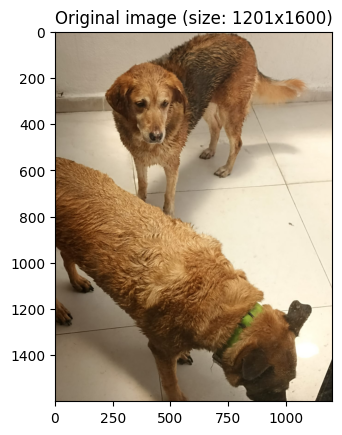

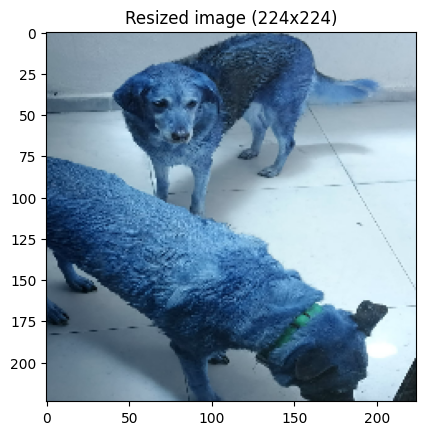

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Raw model output: [[0.9995691]]
Prediction: Dog (confidence: 99.96%)





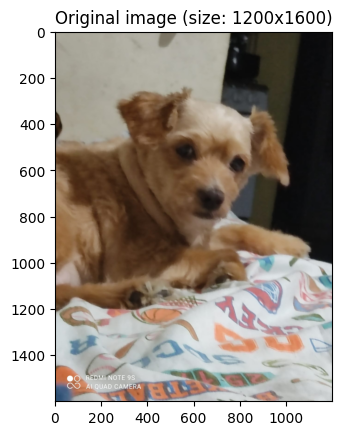

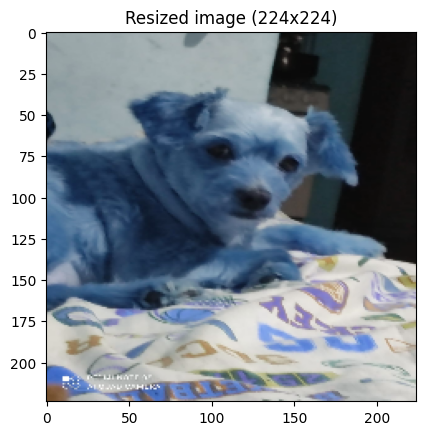

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Raw model output: [[0.999882]]
Prediction: Dog (confidence: 99.99%)





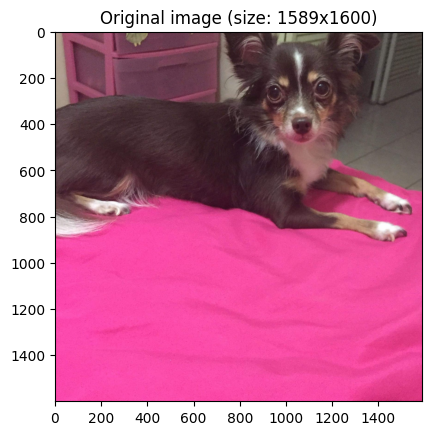

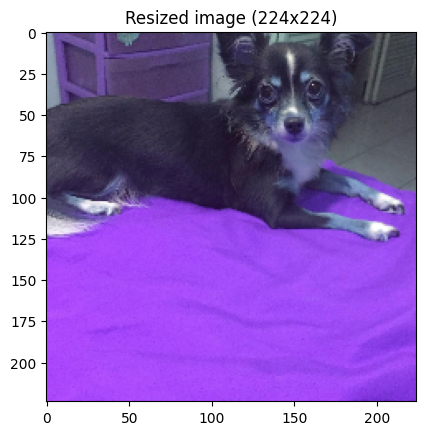

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Raw model output: [[0.9261374]]
Prediction: Dog (confidence: 92.61%)





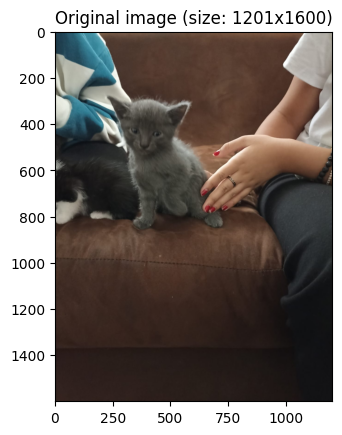

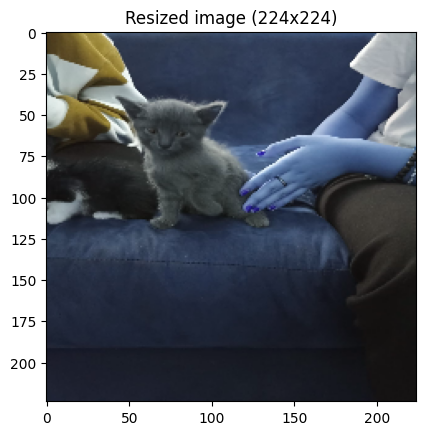

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Raw model output: [[0.05594563]]
Prediction: Cat (confidence: 94.41%)





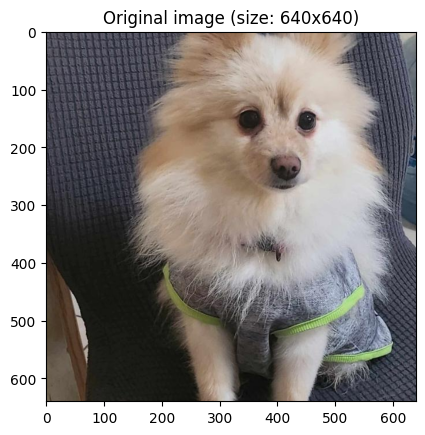

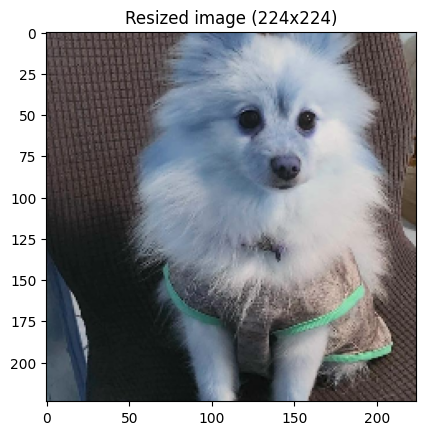

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Raw model output: [[0.9999529]]
Prediction: Dog (confidence: 100.00%)





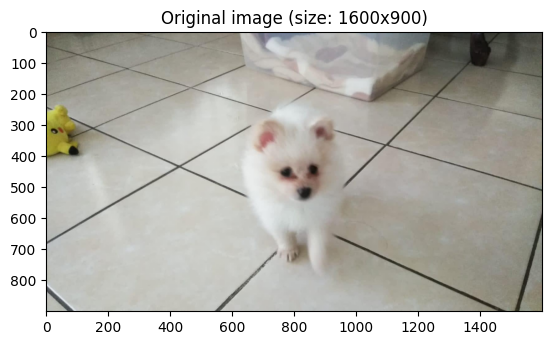

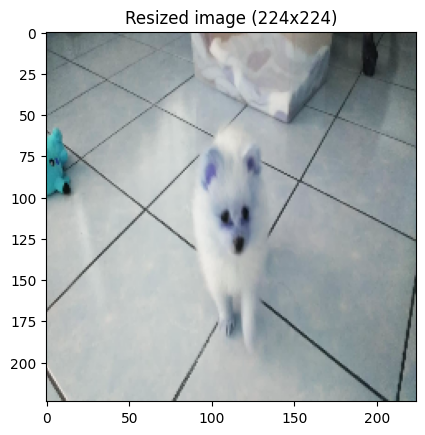

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Raw model output: [[0.3643781]]
Prediction: Cat (confidence: 63.56%)





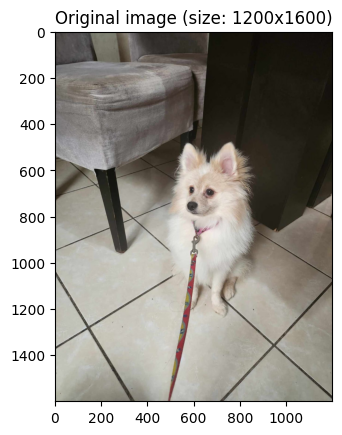

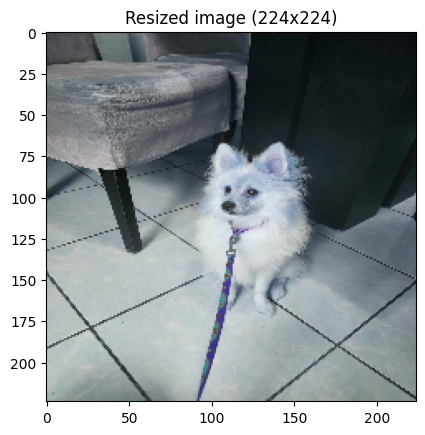

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Raw model output: [[0.9913539]]
Prediction: Dog (confidence: 99.14%)





In [50]:
folder_path = '/content/mascotas'

image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]

for mascota in image_files:
  # Load image
  img_path = os.path.join(folder_path, mascota)
  img = cv2.imread(img_path)

  # Show original image
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title('Original image (size: {}x{})'.format(img.shape[1], img.shape[0]))
  plt.show()

  # 1. Manual resize to 224x224 (required by MobileNet)
  resized_img = tf.image.resize(img, (224, 224))

  # Show resized image
  plt.imshow(resized_img.numpy().astype(int))
  plt.title('Resized image (224x224)')
  plt.show()

  # 2. Add batch dimension (axis=0) - normalization will be handled AUTOMATICALLY by the model
  input_tensor = np.expand_dims(resized_img, axis=0)  # Shape: (1, 224, 224, 3)

  # 3. Predict (normalization happens inside the model)
  yhat = new_model.predict(input_tensor)
  print("Raw model output:", yhat)

  # 4. Decode prediction (adjust threshold based on your model)
  best_threshold = 0.5  # Use the value you determined during training
  pred_class = 'Dog' if yhat >= best_threshold else 'Cat'
  confidence = float(yhat[0][0]) if pred_class == 'Dog' else 1 - float(yhat[0][0])

  print(f'Prediction: {pred_class} (confidence: {confidence:.2%})')
  print('\n\n')